# Comparing IV Estimators

In [63]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from typing import List
import dcor


root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))
    
from dowhy import CausalModel


from causaltune import CausalTune
from causaltune.datasets import iv_dgp_econml
from causaltune.scoring import Scorer
from causaltune.datasets import iv_dgp_econml
from causaltune.params import SimpleParamService
from causaltune.utils import treatment_is_multivalue

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
%%javascript

// turn off scrollable windows for large output
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome

\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
\theta = & \; 7.5\cdot X[2]\cdot X[8] \\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


### Model Fitting (1): Constant Effect (ATE)

We define a constant treatment effect (ATE) to be searched by CausalTune for all named IV estimators.

\begin{align}
\theta = \; & 7.5 \tag{ATE}\\
\end{align}

In [49]:
TRUE_EFFECT = 7.5

CONSTANT_EFFECT = lambda X: TRUE_EFFECT

cd = iv_dgp_econml(
    n=50000, 
    p=15, 
    true_effect=CONSTANT_EFFECT
    )

cd.preprocess_dataset()

outcome = cd.outcomes[0]

For each treatment effect example, we fit a list of 4 IV models, scoring them with an energy distance score. The dataset is split into train, validation and a hold-out test set, and we report scores for each.

The components time budget represent tuning budget allocated to each estimator model.

In [50]:
estimator_list = [
    'iv.econml.iv.dr.SparseLinearDRIV',
    "iv.econml.iv.dml.DMLIV", 
    "iv.econml.iv.dml.OrthoIV", 
    "iv.econml.iv.dr.LinearDRIV", 
    ]

ct_constant_te = CausalTune(
    estimator_list=estimator_list,
    components_time_budget=90,
    propensity_model="dummy",
    metrics_to_report=['ate']
)

ct_constant_te.fit(data=cd, outcome=outcome)


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearIntentToTreatDRIV', 'cov_clip': 0.1, 'opt_reweighted': 1}}]


 We get the estimated effect for the best estimator by energy distance score

In [64]:
def get_est_effects(models, test_x, metric, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        est_score_metric = scr['scores']['validation'][metric]
        est_scores.append([est_name, est_effect, (est_effect-te)**2, est_score_metric])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse", metric])


In [65]:
for est, scr in ct_constant_te.scores.items():
    print(scr['scores'])

{'train': {'ate': 3.6587573018220296, 'ate_std': 0.2120941770303501, 'energy_distance': 0.7061227121685265}, 'validation': {'ate': 3.659523154322003, 'ate_std': 0.21267216723581409, 'energy_distance': 0.7260301166932219}, 'test': {'ate': 3.6601023136720645, 'ate_std': 0.2113365684949257, 'energy_distance': 0.8196693253533471}}
{'train': {'ate': 7.465281466258064, 'ate_std': 0.14842815267202944, 'energy_distance': 0.0005052401655989414}, 'validation': {'ate': 7.4659291946002675, 'ate_std': 0.14728470024896367, 'energy_distance': 0.002821829812681642}, 'test': {'ate': 7.465431273827661, 'ate_std': 0.14746076535079047, 'energy_distance': 0.00895877486749086}}
{'train': {'ate': 3.6578872921389367, 'ate_std': 0.12417663903417193, 'energy_distance': 0.7063608433154576}, 'validation': {'ate': 3.658135815552011, 'ate_std': 0.12410049366507657, 'energy_distance': 0.7260461354608321}, 'test': {'ate': 3.6589021085747153, 'ate_std': 0.12373082545821416, 'energy_distance': 0.8199499773748142}}
{'tr

First we see the estimated effect for each model, and respective MSE compared with true effect

In [66]:
get_est_effects(ct_constant_te, ct_constant_te.test_df, 'energy_distance')

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.econml.iv.dml.DMLIV,3.659523,14.749262,0.726030
1,iv.econml.iv.dml.OrthoIV,7.465929,0.001161,0.002822
2,iv.econml.iv.dr.LinearDRIV,3.658136,14.759920,0.726046
3,iv.econml.iv.dr.SparseLinearDRIV,5.541865,3.834293,0.199448


Best estimator, config and score:

In [67]:
print("(CausalTune Best Estimator)")
print(f"Estimator: {ct_constant_te.best_estimator}")
print(f"Config: {ct_constant_te.best_config}")
print(f"Energy distance score: {ct_constant_te.best_score}")

(CausalTune Best Estimator)
Estimator: iv.econml.iv.dml.OrthoIV
Config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}
Energy distance score: 0.002821829812681642


In the plots we show the energy distance scores on the train, validation and hold-out test sets compared with the mean squared error between estimated effect and the true effect

In [55]:
cd_holdout_constant_te = iv_dgp_econml(
    n=10000, 
    p=15, 
    true_effect=CONSTANT_EFFECT
    )

cd_holdout_constant_te.preprocess_dataset()
ct_constant_te.score_dataset(df=cd_holdout_constant_te.data, dataset_name='test')

In [56]:
from causaltune.visualizer import Visualizer

viz = Visualizer(
    test_df=cd_holdout_constant_te.data,
    treatment_col_name=cd_holdout_constant_te.treatment,
    outcome_col_name=cd_holdout_constant_te.outcomes[0]
)

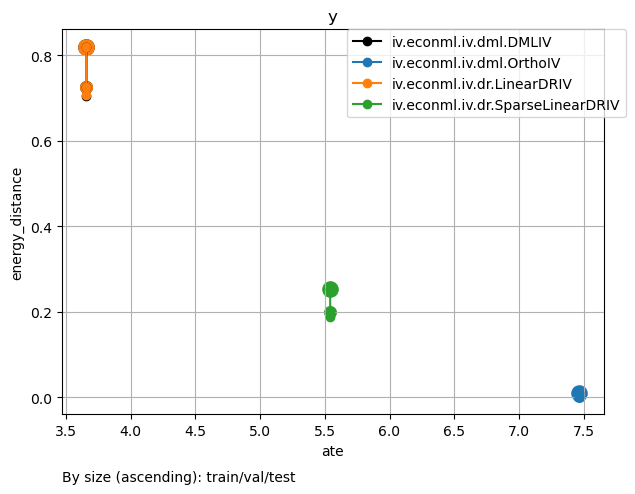

In [57]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct_constant_te.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)

### Baseline Estimators

For comparison, we take the best default configuration of all integrated IV estimators as a baseline, and compare the ATE and energy distance scores, with the best CausalTune configuration.

We perform this comparison for the constant treatment effect only but a similar analysis would be feasible for heterogeneous treatment effect models as well. Note that this analysis hinges on the fact that we use synthetic data and know the true treatment effect.

In [58]:
params = SimpleParamService(propensity_model=None, outcome_model=None, multivalue=treatment_is_multivalue(cd.treatment))

In [74]:
def baseline_scores(ct, cd, iv_estimators):
    # Baseline comparisons: IV models with default conigurations
    baseline_scores = {}
    for est_name in iv_estimators:
        model = CausalModel(
            data=ct.train_df,
            treatment=cd.treatment,
            outcome=outcome,
            effect_modifiers=cd.effect_modifiers,
            common_causes=["random"],
            instruments=cd.instruments,
        )
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
        estimate = model.estimate_effect(
            identified_estimand,
            method_name=est_name,
            method_params={
                "init_params": {},
                "fit_params": {},
            },
            test_significance=False,
        )

        base_effect_ = estimate.estimator.effect(ct.test_df).mean()
        base_energy_dist = Scorer.energy_distance_score(estimate, ct.test_df)

        baseline_scores[est_name] = {
            "effect": base_effect_,
            "energy_distance": base_energy_dist
        }

    baseline_estimator, baseline_metrics = sorted(baseline_scores.items(), key=lambda x: x[1]["energy_distance"])[0]
    return baseline_estimator, baseline_metrics, estimate


baseline_estimator, baseline_metrics, estimate = baseline_scores(ct_constant_te, cd, estimator_list)
print("(Best baseline)")
print("Estimator: ", baseline_estimator)
print("Energy distance score: ", baseline_metrics["energy_distance"])


(Best baseline)
Estimator:  iv.econml.iv.dml.DMLIV
Energy distance score:  0.002399240023787108


#### Comparing Treatment Effect

In [75]:
print("True Treatment Effect  = ", TRUE_EFFECT)
print("(Baseline) Treatment Effect: ", baseline_metrics["effect"])
print("(CausalTune) Treatment Effect: ", ct_constant_te.model.effect(ct_constant_te.test_df).mean())

True Treatment Effect  =  7.5
(Baseline) Treatment Effect:  7.5388046776020285
(CausalTune) Treatment Effect:  7.4659291946002675


Next, we 
- compare the energy distance score for the baseline estimator and the CausalTune estimator, and
- build upper and lower bound benchmarks of the energy score.

In [76]:
# Needed since ct.model.estimator doesn't include additional params -
# treatment, outcome etc. - needed from CausalEstimate instance
def energy_scorer_patch(
    df: pd.DataFrame,
    treatment: str,
    outcome: str,
    instrument: str,
    effect_modifiers: List[str],
    **kwargs
):
    if "estimate" in kwargs.keys():
        df["dy"] = kwargs["estimate"].estimator.effect(df[effect_modifiers])
    # Compute Energy distance for True & No Effect
    elif "true_effect" in kwargs.keys() and "ne" in kwargs.keys():
        df["dy"] = (
            [0] * len(df) if kwargs["ne"] is True
            else [kwargs["true_effect"]] * len(df)
        )

    df.loc[df[treatment] == 0, "dy"] = 0
    df["yhat"] = df[outcome] - df["dy"]

    X1 = df[df[instrument] == 1]
    X0 = df[df[instrument] == 0]
    select_cols = effect_modifiers + ["yhat"]

    energy_distance_score = dcor.energy_distance(X1[select_cols], X0[select_cols])

    return energy_distance_score

In [79]:
print("Energy distance scores")
base_estimator_edist = Scorer.energy_distance_score(estimate, ct_constant_te.test_df)
ac_estimator_edist = energy_scorer_patch(
    ct_constant_te.test_df, cd.treatment, outcome, cd.instruments[0], cd.effect_modifiers, estimate=ct_constant_te.model
)
ac_estimator_edist_ne = energy_scorer_patch(
    ct_constant_te.test_df, cd.treatment, outcome, cd.instruments[0], cd.effect_modifiers, true_effect=TRUE_EFFECT, ne=True
)
ac_estimator_edist_te = energy_scorer_patch(
    ct_constant_te.test_df, cd.treatment, outcome, cd.instruments[0], cd.effect_modifiers, true_effect=TRUE_EFFECT, ne=False
)

print("\nThe baseline and CausalTune energy scores are:")
print(f"\n(Baseline) Energy distance score: {base_estimator_edist:5f}")
print(f"(CausalTune) Energy distance score: {ac_estimator_edist:5f}")

print("\nThe energy distance between treatment and control is")
print(f"(No Effect) Energy distance score: {ac_estimator_edist_ne:5f}")
print("This can be seen as an upper bound on the achievable energy score since \n" +
      "it calculates the energy score under the assumption that there is no treatment effect.\n\n\n")


print("If we remove the true treatment effect (which is known in this case)\n" +
      "from the treated units and compare the resulting outcomes with the control group,\n" + 
      " the energy distance becomes")
print(f"(True Effect) Energy distance score: {ac_estimator_edist_te:5f}")
print("This can be seen as a lower bound on the achievable energy distance as \n" +
      "the de-treated treatment and the control outcome distributions follow the same data generating process.")

Energy distance scores

The baseline and CausalTune energy scores are:

(Baseline) Energy distance score: 0.002633
(CausalTune) Energy distance score: 0.002744

The energy distance between treatment and control is
(No Effect) Energy distance score: 2.541892
This can be seen as an upper bound on the achievable energy score since 
it calculates the energy score under the assumption that there is no treatment effect.



If we remove the true treatment effect (which is known in this case)
from the treated units and compare the resulting outcomes with the control group,
 the energy distance becomes
(True Effect) Energy distance score: 0.002466
This can be seen as a lower bound on the achievable energy distance as 
the de-treated treatment and the control outcome distributions follow the same data generating process.


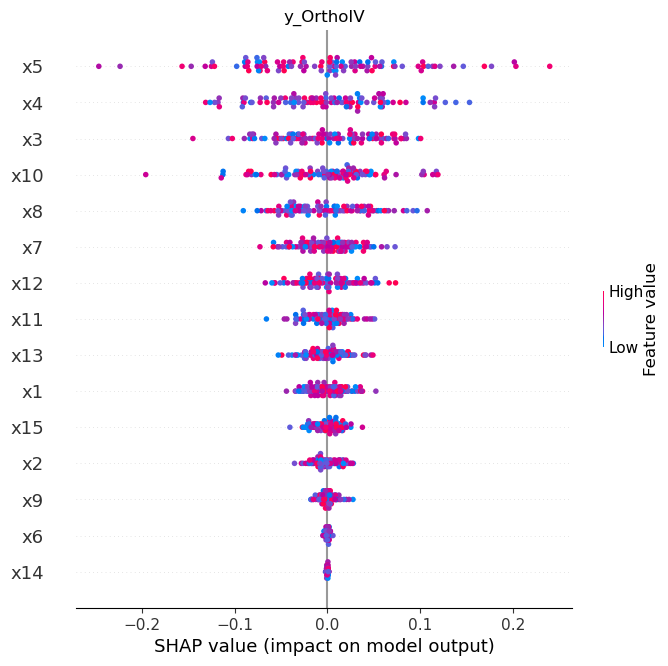

In [78]:
# Feature importance with SHAP explainer
import matplotlib.pyplot as plt
import shap

# and now let's visualize feature importances!
from causaltune.shap import shap_values

# Shapley values calculation can be slow so let's subsample
this_df = ct_constant_te.test_df.sample(100)

scr = ct_constant_te.scores[ct_constant_te.best_estimator]
est = ct_constant_te.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ct_constant_te.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[cd.effect_modifiers])
plt.show()

### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [80]:
LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] + X[:, 7])

cd = iv_dgp_econml(n=5000, p=15, true_effect=LINEAR_EFFECT)
cd.preprocess_dataset()

outcome = cd.outcomes[0]

In [81]:
ct_linear_te = CausalTune(
    estimator_list=estimator_list,
    components_time_budget=60,
    propensity_model="dummy",
)

ct_linear_te.fit(data=cd, outcome=outcome)

Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}]


In [82]:
get_est_effects(ct_linear_te, ct_linear_te.test_df, 'energy_distance')

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.econml.iv.dml.DMLIV,-0.559407,64.954037,0.080734
1,iv.econml.iv.dml.OrthoIV,-0.865709,69.985092,0.043433
2,iv.econml.iv.dr.LinearDRIV,-0.479235,63.668190,0.101972
3,iv.econml.iv.dr.SparseLinearDRIV,-0.543763,64.702125,0.073483


In [83]:
cd_holdout_linear_te = iv_dgp_econml(
    n=30000, 
    p=15, 
    true_effect=LINEAR_EFFECT
    )

cd_holdout_linear_te.preprocess_dataset()
ct_linear_te.score_dataset(df=cd_holdout_linear_te.data, dataset_name='test')

viz = Visualizer(
    test_df=cd_holdout_linear_te.data,
    treatment_col_name=cd_holdout_linear_te.treatment,
    outcome_col_name=cd_holdout_linear_te.outcomes[0]
)

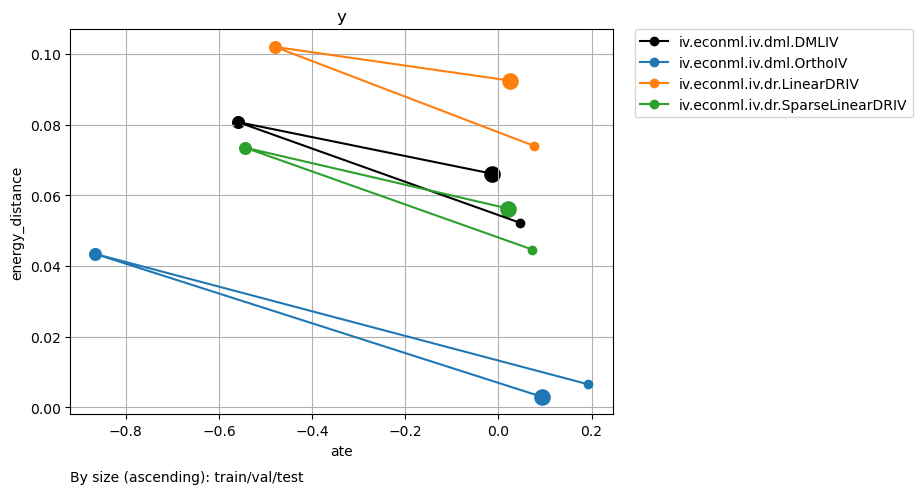

In [84]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct_linear_te.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)

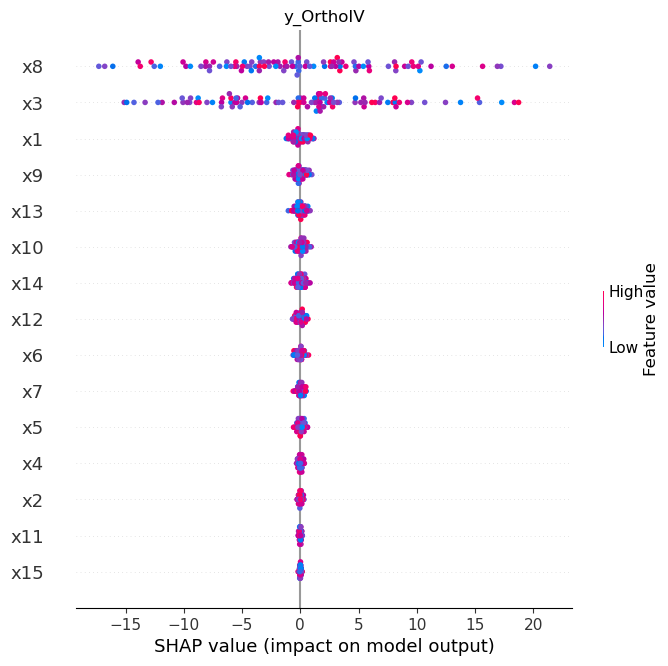

In [85]:
# Shapley values calculation can be slow so let's subsample
this_df = ct_linear_te.test_df.sample(100)

scr = ct_linear_te.scores[ct_linear_te.best_estimator]
est = ct_linear_te.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ct_linear_te.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[cd.effect_modifiers])
plt.show()

### Model Fitting (3): Non-linear Heterogeneous Treatment Effect

Finally we explore non-linear heterogeneous treatment effects with the function below:

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}


In [86]:
QUADRATIC_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] ** 2)

cd = iv_dgp_econml(n=5000, p=15, true_effect=QUADRATIC_EFFECT)
cd.preprocess_dataset()

outcome = cd.outcomes[0]
cd.data.head()

,y,treatment,Z,random,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
0,6.217977,0,0,0.0,0.449373,-0.664156,0.142750,0.333380,0.076627,-0.072835,0.640475,1.006988,0.745913,-0.484027,-0.260730,1.194747,0.382013,0.556873,-0.139058
1,23.855850,1,1,0.0,-0.850771,-0.686780,-1.465715,-0.736871,0.608843,-0.277723,-0.585572,-0.182962,1.165760,-0.264437,0.553148,-1.921674,-0.733251,-0.925882,1.236508
2,43.222108,1,1,0.0,-0.165029,0.070267,-2.246133,1.387414,0.529701,-0.485374,0.481825,1.397670,1.717529,0.308166,1.293859,0.464600,-0.765668,0.292529,-0.958925
3,0.258738,0,0,1.0,1.051790,1.197665,-0.646686,-0.619009,0.573426,1.005463,1.716961,-0.136543,0.417223,-0.866058,0.673982,-0.346598,-0.666294,1.567623,1.497358
4,26.760363,1,1,1.0,-2.147729,0.624663,1.546067,-0.452222,-0.787933,0.136457,0.055029,-1.309542,-0.511940,0.185796,0.588358,-0.189125,1.694611,-0.362455,1.704416


In [87]:
ct_quad_te = CausalTune(
    estimator_list=estimator_list,
    components_time_budget=60,
    propensity_model="dummy",
)

ct_quad_te.fit(data=cd, outcome=outcome)


Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dr.LinearDRIV', 'projection': True}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dml.DMLIV', 'mc_agg': 'mean'}}, {'estimator': {'estimator_name': 'iv.econml.iv.dr.SparseLinearDRIV', 'projection': 0, 'opt_reweighted': 0, 'cov_clip': 0.1}}]


In [88]:
get_est_effects(ct_quad_te, ct_quad_te.test_df, 'energy_distance')

,estimator,estimated_effect,ate_mse,energy_distance
0,iv.econml.iv.dml.DMLIV,3.881024,13.096986,0.461051
1,iv.econml.iv.dml.OrthoIV,7.305954,0.037654,0.330434
2,iv.econml.iv.dr.LinearDRIV,3.945438,12.634910,0.458119
3,iv.econml.iv.dr.SparseLinearDRIV,4.863756,6.949784,0.358877


In [89]:
cd_holdout_quad_te = iv_dgp_econml(
    n=20000, 
    p=15, 
    true_effect=QUADRATIC_EFFECT
    )

cd_holdout_quad_te.preprocess_dataset()
ct_quad_te.score_dataset(df=cd_holdout_quad_te.data, dataset_name='test')

viz = Visualizer(
    test_df=cd_holdout_quad_te.data,
    treatment_col_name=cd_holdout_quad_te.treatment,
    outcome_col_name=cd_holdout_quad_te.outcomes[0]
)

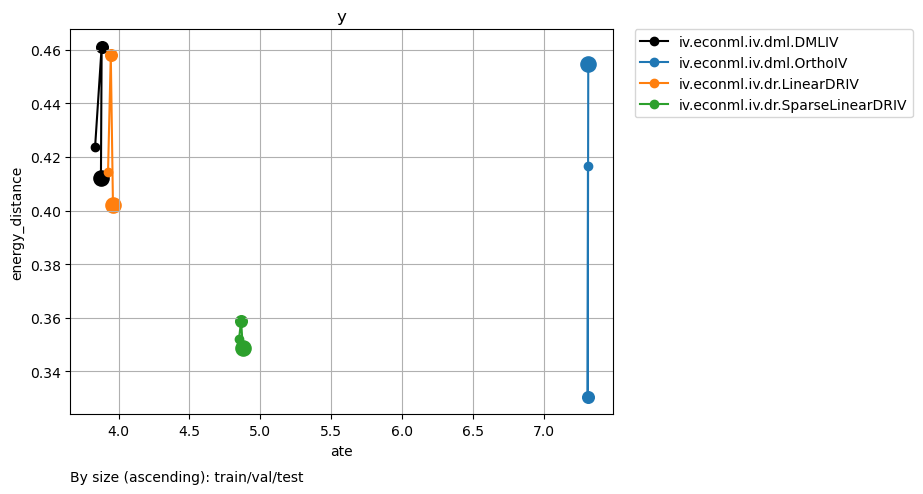

In [90]:
%matplotlib inline

# plotting metrics by estimator

figtitle = f'{viz.outcome_col_name}'
figsize = (7,5)
metrics = ('energy_distance', 'ate')

viz.plot_metrics_by_estimator(
    scores_dict=ct_quad_te.scores,
    metrics=metrics,
    figtitle=figtitle,
    figsize=figsize
)

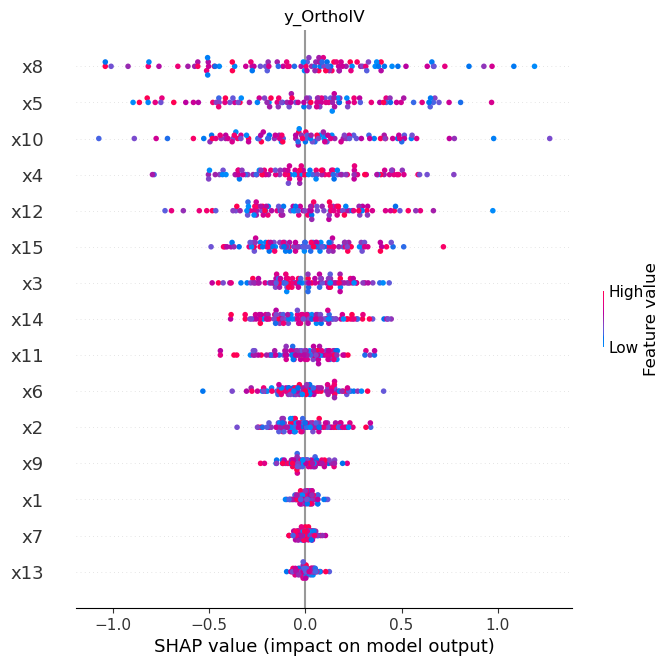

In [91]:
# Shapley values calculation can be slow so let's subsample
this_df = ct_quad_te.test_df.sample(100)

scr = ct_quad_te.scores[ct_quad_te.best_estimator]
est = ct_quad_te.model
shaps = shap_values(est, this_df)

plt.title(outcome + '_' + ct_quad_te.best_estimator.split('.')[-1])
shap.summary_plot(shaps, this_df[cd.effect_modifiers])
plt.show()